# "Euphotic zone residence time of Antarctic Bottom Water"

### Code for Analyzing the Sensitivity of different CDW depth thresholds (cut-off depths) 

Corresponding to Yinghuan Xie (yinghuan.xie@utas.edu.au)

In [1]:
# Importing the relevant modules. 
import numpy as np
import xarray as xr
import math
import time
import datetime as dt
from datetime import timedelta
import calendar
import os
import re
from glob import glob
#
import netCDF4 as nc
import pandas as pd
import gsw
#
import cartopy.crs as ccrs
from scipy.io import loadmat
#
import matplotlib.pyplot as plt
import matplotlib.colors as col
#
import cosima_cookbook as cc
session =cc.database.create_session()
expt = '01deg_jra55v13_ryf9091'
#
from os import sys
sys.path.append('/home/581/yx9454/PhD_Ch1')
from My_Py_Func import Ch1_defs as c1d

In [7]:
# In each experiment, we define 06-18, release-06, 05-release, 87-05,
# loop_start_point-87 (if availiable) as No 0,1,2,3,4(if availiable)

master_path = '/g/data/jk72/yx9454/runs/parcels/output_after_Aug/'
traj_input = {'MLS_ON':[{'out_freq': 5,
                        'exp_path':'CORE_Curtain_Forward(out_freq=5days)_Following_MLS_ON/'},
                        {'out_freq': 5,
                        'exp_path':'CORE_Curtain_Forward(out_freq=5days)_Jan-Dec_MLS_ON/'},
                        {'out_freq': 0.25,
                        'exp_path':'CORE_Curtain_Backwards(out_freq=6hrs)_Jan-Dec_MLS_ON/'},
                        {'out_freq': 5, # Here we only load 5days frequency 
                        'exp_path':'CORE_Curtain_Backwards(out_freq=6hrs)_Following_MLS_ON/'},
                        {'out_freq': 5, # Here we only load 5days frequency 
                        'exp_path':'CORE_Curtain_Backwards(out_freq=6hrs)_Following_Loop_MLS_ON/'}],
        }

In [3]:
## This chunk is for loading the traj files
exp_name = 'MLS_ON'
variables = {'id':'trajectory',  'x': 'lon'   ,'y': 'lat'  ,'z': 'z', 'time':'time',
             #'T': 'temperature','S': 'salinity',
             #'ML': 'mixedlayershuffle', 'MLD':'mldepth',
             #'rel_id':'rel_id','rel_z':'rel_z','rel_m':'rel_m',
            }

In [4]:
t = time.time()
var_in_arrs_3 = {}
npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/'+exp_name+'/var_in_arrs_3_5days_freq.npz')
#var_in_arrs_3['x'] = npzfile['x']
print(time.time()-t)
#var_in_arrs_3['y'] = npzfile['y']
print(time.time()-t)
var_in_arrs_3['z'] = npzfile['z']
print(time.time()-t)
var_in_arrs_3['time'] = npzfile['time'] 
print(time.time()-t)

import gc
gc.collect()

0.08801031112670898
0.08816242218017578
16.42868709564209
31.77424454689026


22

In [5]:
t = time.time()
var_in_arrs_4 = {}
npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/'+exp_name+'/var_in_arrs_4_5days_freq.npz')
#var_in_arrs_4['x'] = npzfile['x']
print(time.time()-t)
#var_in_arrs_4['y'] = npzfile['y']
print(time.time()-t)
var_in_arrs_4['z'] = npzfile['z']
print(time.time()-t)
#var_in_arrs_4['T'] = npzfile['T']
print(time.time()-t)
#var_in_arrs_4['S'] = npzfile['S']
print(time.time()-t)
var_in_arrs_4['time'] = npzfile['time'] 
print(time.time()-t)

import gc
gc.collect()

0.21024107933044434
0.21040058135986328
17.014790296554565
17.014902353286743
17.01530361175537
33.2880220413208


22

In [12]:
Duration_away_from_surf_layer = 20 # years
surf_lyr_dep = 150 # Meters

AABW_thre_dep = 2000
AABW_thre_days_0 = 365*2
AABW_thre_days_1 = 365*5

CDW_thre_dep = 1000# Current default:1000

#Forward tracking end time
T0 = dt.datetime(2018,12,21)
#T0 = dt.datetime(2018,12,31) # Full period # was 2018-12-21

#Backward tracking end time
#Loop experiment end time # Any date later than 2018-12-1 is invalid
T01 = dt.datetime(1969,1,5) # Was 1980-1-1 for analysis until 22/03/2023

if T01>= dt.datetime(1987,1,1):
    T1 = T01
    T2 = dt.datetime(2020,9,9) 
elif T01< dt.datetime(1987,1,1):
    T1 = dt.datetime(1987,1,1) # Full period
    T2 = dt.datetime(2018,12,1) - (dt.datetime(1987,1,1) - T01)
else:
    print('Error')

#The comprehensive time includes the loop duration
#if T2 < dt.datetime(2018,12,1):
#    T01= dt.datetime(1987,1,1) - (dt.datetime(2018,12,1) - T2)
#else:
#    T01=T1

ERROR! Session/line number was not unique in database. History logging moved to new session 3969


In [10]:
if exp_name == 'MLS_ON':
    AABW_inds = np.load('/g/data/jk72/yx9454/PAR_from_iaf_cycle4/'+exp_name+'/AABW_inds.npz')['AABW_inds']


# CDW Selection:
# Stop particle tracking if a particle remains away from the surface layer/assigned depth for more than a specified number of years.

In [15]:
def find_beginning_of_continuous_val(mask,times): 
    mask = list(mask)
    # Ref: https://segmentfault.com/q/1010000023727627
    # Add a 0 at the beginning and end for statistics
    mask0 = np.insert(mask, [0, len(mask)], 0)*1
    # sum
    sum0 = np.cumsum(mask0)
    # Take the accumulated value corresponding to the position that does not meet the condition
    sum1 = sum0[mask0 == 0]
    # Remove overlapping items
    sum2 = np.unique(sum1)
    #print('sum2',sum2)
    # Calculate consecutive numbers by the difference
    result = np.diff(sum2)
    #
    ind  = np.argwhere(result>=times)
    if ind.shape == (0,1):
        #print('Not found')
        return(np.nan,1)
    else:
        ind2 = np.argwhere(sum0==sum2[ind[0]+1]).min()
        #print(np.argwhere(sum1==sum2[ind[0]+1]))
        #ind2 += -1
        return(ind2-result[ind[0,0]],0)

### Generate AABW+CDW particles information with different cut-off thresholds
Only need to run once then we directly read the npz file

# Then we start the analysis

In [31]:
# Define the threshld for euphotic zone PAR in (watts per square metres)
# 2  mol/m^2/day: 5.439369304008213
# 3  mol/m^2/day: 8.15905395601232
# 4  mol/m^2/day: 10.878738608016427
PARZ_thre = 8.159
PARZ_thre_L = 5.439
PARZ_thre_U = 10.879

In [32]:
# In each experiment, we define 06-18, release-06, 05-release, 87-05,
# loop_start_point-87 (if availiable) as No 0,1,2,3,4(if availiable)

master_path = '/g/data/jk72/yx9454/runs/parcels/output_after_Aug/'
traj_input = {'MLS_ON':[{'out_freq': 5,
                        'exp_path':'CORE_Curtain_Forward(out_freq=5days)_Following_MLS_ON/'},
                        {'out_freq': 5,
                        'exp_path':'CORE_Curtain_Forward(out_freq=5days)_Jan-Dec_MLS_ON/'},
                        {'out_freq': 0.25,
                        'exp_path':'CORE_Curtain_Backwards(out_freq=6hrs)_Jan-Dec_MLS_ON/'},
                        {'out_freq': 0.25,
                        'exp_path':'CORE_Curtain_Backwards(out_freq=6hrs)_Following_MLS_ON/'},
                        {'out_freq': 0.25,
                        'exp_path':'CORE_Curtain_Backwards(out_freq=6hrs)_Following_Loop_MLS_ON/'}],
}

In [33]:
Chl_a_ver = 'Chl-a_based_on_OCCCI_v6'
var_in_arrs_0,var_in_arrs_1,var_in_arrs_2,var_in_arrs_3,var_in_arrs_4 = {},{},{},{},{}

for exp_name in ['MLS_ON']:
    files = sorted(glob('/g/data/jk72/yx9454/PAR_from_iaf_cycle4/'+exp_name+'/'+Chl_a_ver+'/var_in_arrs_*.npz'))

    var_in_arrs_list = [var_in_arrs_0,var_in_arrs_1,var_in_arrs_2,var_in_arrs_3,var_in_arrs_4]
    for i in [0,1,2,3,4]:
        print(files[i])
        for pvar in ['PARS','PARZ','Pt_ind']:
            PVAR   = np.load(files[i])[pvar]
            var_in_arrs_list[i][exp_name+'_'+pvar]=PVAR
            print(pvar,' loaded')

/g/data/jk72/yx9454/PAR_from_iaf_cycle4/MLS_ON/Chl-a_based_on_OCCCI_v6/var_in_arrs_0_AABW_only_PARS_Z.npz
PARS  loaded
PARZ  loaded
Pt_ind  loaded
/g/data/jk72/yx9454/PAR_from_iaf_cycle4/MLS_ON/Chl-a_based_on_OCCCI_v6/var_in_arrs_1_AABW_only_PARS_Z.npz
PARS  loaded
PARZ  loaded
Pt_ind  loaded
/g/data/jk72/yx9454/PAR_from_iaf_cycle4/MLS_ON/Chl-a_based_on_OCCCI_v6/var_in_arrs_2_AABW_only_PARS_Z.npz
PARS  loaded
PARZ  loaded
Pt_ind  loaded
/g/data/jk72/yx9454/PAR_from_iaf_cycle4/MLS_ON/Chl-a_based_on_OCCCI_v6/var_in_arrs_3_AABW_only_PARS_Z.npz
PARS  loaded
PARZ  loaded
Pt_ind  loaded
/g/data/jk72/yx9454/PAR_from_iaf_cycle4/MLS_ON/Chl-a_based_on_OCCCI_v6/var_in_arrs_4_AABW_only_PARS_Z.npz
PARS  loaded
PARZ  loaded
Pt_ind  loaded


In [48]:
%%time
###-------------------------------------------------------------------------------------------###
total_shallower_than_EZD_days_back_only = {}
total_shallower_than_EZD_days           = {}
means                                   = {}
CDW_number                              = {}
#medians                                 = {}
#p10s                                    = {}
#p90s                                    = {}
#hists                                   = {}
###-------------------------------------------------------------------------------------------###
for surf_lyr_dep   in [0,50,100,150,200,300,400,500,600,700,800,900,1000]:
    if surf_lyr_dep != 0:
        CDW_inds = np.load('/g/data/jk72/yx9454/PAR_from_iaf_cycle4/MLS_ON/CDW_inds_for_20yrs_'+str(int(surf_lyr_dep))+'_thre.npz')['CDW_inds']
    
    ### For PARZ_thre lower limit  ---------------------------------------------------------------###
    for PARZ_info,PARZ_thre_here in zip(['PARZ_thre'],
                                        [PARZ_thre]):
    
        # Backwards following
        #total_seconds = (T1 - dt.datetime(1970,1,1)).total_seconds()
        ind_t = -1
        out_freq = traj_input[exp_name][3]['out_freq']
        following    = np.sum(var_in_arrs_3[exp_name+'_PARZ'][:,:ind_t]>PARZ_thre_here,axis=1)*out_freq
        
        # Backwards first year
        out_freq = traj_input[exp_name][2]['out_freq']
        first_yr = np.sum((var_in_arrs_2[exp_name+'_PARZ'][:,:]>PARZ_thre_here),axis=1)*out_freq
        
        #The loop exp, starts from 2018-12-1
        ind_t = -1
        
        out_freq = traj_input[exp_name][4]['out_freq']
        loop = np.sum((var_in_arrs_4[exp_name+'_PARZ'][:,:ind_t]>PARZ_thre_here),axis=1)*out_freq
        
        # Forwards first year
        if True:
            out_freq = traj_input[exp_name][0]['out_freq']
            following_forward = np.sum((var_in_arrs_0[exp_name+'_PARZ'][:,:]>PARZ_thre_here),axis=1)*out_freq
        
        # Forwards following
        if True:
            ind_t = -1
            out_freq = traj_input[exp_name][1]['out_freq']
            first_yr_forward = np.sum((var_in_arrs_1[exp_name+'_PARZ'][:,:ind_t]>PARZ_thre_here),axis=1)*out_freq
        
        total_shallower_than_EZD_days_back_only[PARZ_info] = following + first_yr + loop
        total_shallower_than_EZD_days[PARZ_info]           = following + first_yr + following_forward + first_yr_forward + loop

        if surf_lyr_dep != 0:
            AABW_shallower_than_EZD_plus_CDW =  (total_shallower_than_EZD_days[PARZ_info]>0) & (CDW_inds)
        else:
            AABW_shallower_than_EZD_plus_CDW =  (total_shallower_than_EZD_days[PARZ_info]>0) 
        
        
        #mean_lower = np.mean(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1)
        means[surf_lyr_dep] = np.mean(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1)
        #medians[PARZ_info] = np.median(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1)
        #p10s[PARZ_info] = np.percentile(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1,10)
        #p90s[PARZ_info] = np.percentile(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1,90)
        
        if surf_lyr_dep != 0:
            CDW_number[surf_lyr_dep] = np.sum(CDW_inds)
        else:
            CDW_number[surf_lyr_dep] = AABW_shallower_than_EZD_plus_CDW.shape[0]
    
        print('surf_lyr_dep=',surf_lyr_dep,' calculation done')

surf_lyr_dep= 0  calculation done
surf_lyr_dep= 50  calculation done
surf_lyr_dep= 100  calculation done
surf_lyr_dep= 150  calculation done
surf_lyr_dep= 200  calculation done
surf_lyr_dep= 300  calculation done
surf_lyr_dep= 400  calculation done
surf_lyr_dep= 500  calculation done
surf_lyr_dep= 600  calculation done
surf_lyr_dep= 700  calculation done
surf_lyr_dep= 800  calculation done
surf_lyr_dep= 900  calculation done
surf_lyr_dep= 1000  calculation done
CPU times: user 1min 48s, sys: 22.6 s, total: 2min 11s
Wall time: 2min 11s


In [76]:
means,CDW_number,list(means.values())/means[150]

({0: 41.95373182552504,
  50: 39.77247841650874,
  100: 39.53545234450102,
  150: 39.16186087990488,
  200: 38.62785700138641,
  300: 37.54564935365797,
  400: 36.86377105855238,
  500: 36.12793442622951,
  600: 35.27014357445473,
  700: 34.83950325809803,
  800: 34.46291303350161,
  900: 34.32646443514644,
  1000: 34.01488451668092},
 {0: 94123,
  50: 91059,
  100: 90571,
  150: 89070,
  200: 86779,
  300: 81112,
  400: 75245,
  500: 69275,
  600: 63360,
  700: 57732,
  800: 52139,
  900: 46799,
  1000: 41858},
 array([1.07129056, 1.01559215, 1.00953968, 1.        , 0.98636419,
        0.95872996, 0.94131817, 0.92252854, 0.90062481, 0.88962839,
        0.88001214, 0.87652792, 0.86857171]))

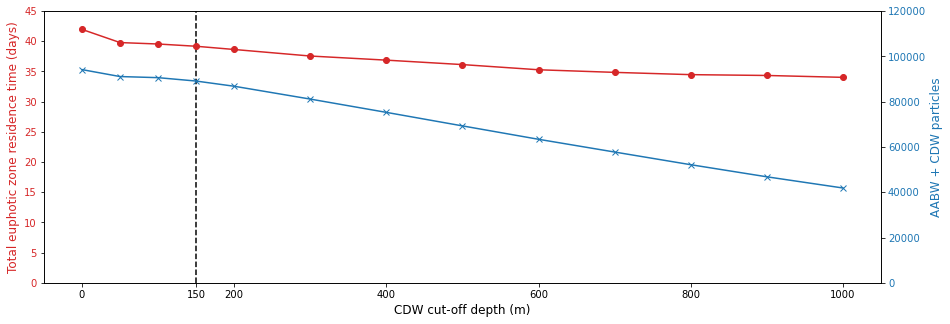

In [73]:

# Extracting keys and values
x1, y1 = list(means.keys()), )
x2, y2 = list(CDW_number.keys()), list(CDW_number.values())


# Creating a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(15, 5))

# First dataset
color = 'tab:red'
ax1.set_xlabel('CDW cut-off depth (m)',fontsize=12)
ax1.set_ylabel('Total euphotic zone residence time (days)', color=color,fontsize=12)
ax1.plot([150,150],[0,45],'k--')
ax1.plot(x1, y1, marker='o', color=color, label='Dataset 1')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0,45)


# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('AABW + CDW particles', color=color,fontsize=12)  
ax2.plot(x2, y2, marker='x', color=color, label='Dataset 2')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,120000)
# Manually setting x-ticks
ax1.set_xticks([0,150,200,400,600,800,1000])  # Update this line for manual x-ticks

# Title and legend
#fig.legend(loc="upper right")

plt.savefig('Revision_Figure_test_CDW_depth_cut-off.png',dpi=500)

